In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# GPU
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2

## Define model

In [31]:
def set_seed(seed=0):
    import random
    import numpy as np
    import torch
    import dgl
    import os

    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Cho multi-GPU
    torch.backends.cudnn.deterministic = True  # Quan trọng!
    torch.backends.cudnn.benchmark = False  # Tắt tối ưu tự động

    # DGL
    dgl.random.seed(seed)

# GloVe 200

In [4]:
def many_word_to_word(text):
    split_text = text.split()
    if len(split_text) > 1:
        return split_text[0]
    else:
        return text

In [5]:
def load_glove():
    """Loads glove's embeddings

    Returns:
        A dictionary with glove embeddings.
    """
    glove_dict = {}
    with open('/content/drive/MyDrive/Dataset/glove.6B.200d.txt', encoding="utf-8") as f:
        for line in f:
            word_, *vector = line.split()
            glove_dict[word_] = [float(x) for x in vector]

    return glove_dict

# Load GloVe
glove_object = load_glove()

def fetch_glove_embeddings(word, memory=True):
    """Fetches a representation from glove given an input word

    Arguments:
        word -- word to seek representations
        memory -- keep a cache of previous representations (default: {True})

    Returns:
        embedding of given word
    """

    word = word.lower()
    if word == 'doubt/confusion':
        word = 'confusion'

    word = many_word_to_word(word)
    if memory:
        try:
            return glove_object[word]
        except KeyError:
            with open('/content/drive/MyDrive/Dataset/glove.6B.200d_mod.txt', 'a') as f:
                string = ''
                string = string+word
                vector = list(np.random.uniform(low=-1, high=1, size=(200,)))
                for val in vector:
                    string = string + ' ' + str("%.6f" % val)
                f.write('\n'+string)
                glove_object[word] = vector
                return glove_object[word]


# Matrices

In [6]:
def convert_to_numpy_array(input_string):
    # The input is already a list after processing the dataframe
    # No need to call eval() again.
    # list_numbers = eval(input_string)
    list_numbers = input_string

    # Chuyển list thành numpy array
    numpy_array = np.array(list_numbers, dtype=float)

    # Chia mỗi phần tử cho 10
    return numpy_array

In [7]:
import pandas as pd
import ast

# file_processed = pd.read_csv('/content/drive/MyDrive/KLTN/Dataset/emotic_pre/captions_train.csv')

df = pd.read_csv('/content/drive/MyDrive/Dataset/EMOTIC/caption_full.csv', encoding='latin-1')  # or 'iso-8859-1' or 'cp1252'

df['Categorical_Labels'] = df['Categorical_Labels'].apply(eval)  # Chuyển chuỗi thành list
df['Continuous_Labels'] = df['Continuous_Labels'].apply(eval)
df['Processed_Caption'] = df['processed_caption'].apply(eval)
# df['Categorical_Labels'] = df['Categorical_Labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



In [8]:
# Danh sách cảm xúc từ EMOTIC (26 danh mục)
emotions = [
    "Affection", "Anger", "Annoyance", "Anticipation", "Aversion", "Confidence", "Disapproval",
    "Disconnection", "Disquietment", "Doubt/Confusion", "Embarrassment", "Engagement", "Esteem",
    "Excitement", "Fatigue", "Fear", "Happiness", "Pain", "Peace", "Pleasure", "Sadness",
    "Sensitivity", "Suffering", "Surprise", "Sympathy", "Yearning"
]

In [9]:
import numpy as np

# Tập hợp tất cả valid words
all_valid_words = set()
for words in df['Processed_Caption']:
    all_valid_words.update(words)

all_valid_words = list(all_valid_words)
word_to_idx = {word: i for i, word in enumerate(all_valid_words)}
emotion_to_idx = {emo: i for i, emo in enumerate(emotions)}

# Tạo ma trận Mc và Ms
W, C = len(all_valid_words), len(emotions)
Mc = np.zeros((W, C))  # Word-emotion
Ms = np.zeros((W, W))  # Word-word

for _, row in df.iterrows():
    words = row['Processed_Caption']
    emos = row['Categorical_Labels']
    for word in words:
        w_idx = word_to_idx[word]
        for emo in emos:
            if emo in emotion_to_idx:  # Kiểm tra nếu nhãn có trong danh sách
                Mc[w_idx, emotion_to_idx[emo]] += 1
        for other_word in words:
            Ms[w_idx, word_to_idx[other_word]] += 1

print("Mc shape:", Mc.shape)
print("Ms shape:", Ms.shape)

Mc shape: (1628, 26)
Ms shape: (1628, 1628)


In [10]:
def create_matrices(df, emotions):
    """Tạo ma trận W-W (Ms) và W-Emotion (Mc) từ dữ liệu."""
    all_valid_words = set()
    for words in df['Processed_Caption']:
        all_valid_words.update(words)

    all_valid_words = list(all_valid_words)
    word_to_idx = {word: i for i, word in enumerate(all_valid_words)}
    emotion_to_idx = {emo: i for i, emo in enumerate(emotions)}

    W, C = len(all_valid_words), len(emotions)
    Mc = np.zeros((W, C))  # Word-emotion
    Ms = np.zeros((W, W))  # Word-word

    for _, row in df.iterrows():
        words = row['Processed_Caption']
        emos = row['Categorical_Labels']
        for word in words:
            w_idx = word_to_idx[word]
            for emo in emos:
                if emo in emotion_to_idx:
                    Mc[w_idx, emotion_to_idx[emo]] += 1
            for other_word in words:
                Ms[w_idx, word_to_idx[other_word]] += 1

    return Ms, Mc, word_to_idx, emotion_to_idx

###  GIN

In [11]:
import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling

class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)

class GIN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, pooling_type='SumPooling'):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.pooling_type = pooling_type
        num_layers = 5

        for layer in range(num_layers):
            if layer == 0:
                mlp = MLP(in_feats, h_feats, h_feats)
            else:
                mlp = MLP(h_feats, h_feats, h_feats)
            self.ginlayers.append(GINConv(mlp, learn_eps=False))
            self.batch_norms.append(nn.BatchNorm1d(h_feats))

        self.linear_prediction = nn.Linear(h_feats, num_classes)
        self.vad_prediction = nn.Linear(h_feats, 3)

        self.drop = nn.Dropout(0.3)
        if self.pooling_type == 'SumPooling':
            self.pool = SumPooling()
        elif self.pooling_type == 'AvgPooling':
            self.pool = AvgPooling()

    def forward(self, g, h, edge_weight):
        hidden_rep = [h]
        # Corrected indentation here
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h, edge_weight = edge_weight)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        score_over_vad = 0
        # Corrected indentation here
        for i, layer in enumerate(self.ginlayers):
            pooled_h = self.pool(g, h)
            score_over_layer = self.drop(self.linear_prediction(pooled_h))
            score_over_vad = self.drop(self.vad_prediction(pooled_h))

        return score_over_layer, score_over_vad

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


In [12]:
import numpy as np
from torch.utils.data import Dataset
import csv
import dgl
import torch
from sklearn.metrics import average_precision_score, precision_recall_curve

'''
Check lại EmoticDataset(Dataset)
'''
class EmoticDataset(Dataset):
    def __init__(self, cat, cont):
        super(EmoticDataset, self).__init__()
        self.cat = cat
        self.cont = cont

    def __len__(self):
        return len(self.cat)

    def __getitem__(self, index):
        cat_label = self.cat[index]
        cont_label = self.cont[index]

        return torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0, index

def test_scikit_ap(cat_preds, cat_labels, ind2cat):
    '''
    Calculate average precision per emotion category using sklearn library.
    :param cat_preds: Categorical emotion predictions.
    :param cat_labels: Categorical emotion labels.
    :param ind2cat: Dictionary converting integer index to categorical emotion.
    :return: Numpy array containing average precision per emotion category.
    '''
    ap = np.zeros(26, dtype=np.float32)
    for i in range(26):
        ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
        #print ('Category %16s %.5f' %(ind2cat[i], ap[i]))
    #print ('Mean AP %.5f' %(ap.mean()))
    return ap.mean()

def test_vad(cont_preds, cont_labels, ind2vad):
    ''' Calcaulate VAD (valence, arousal, dominance) errors.
    :param cont_preds: Continuous emotion predictions.
    :param cont_labels: Continuous emotion labels.
    :param ind2vad: Dictionary converting integer index to continuous emotion dimension (Valence, Arousal and Dominance).
    :return: Numpy array containing mean absolute error per continuous emotion dimension.
    '''
    vad = np.zeros(3, dtype=np.float32)
    for i in range(3):
        vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
        #print ('Continuous %10s %.5f' %(ind2vad[i], vad[i]))
    #print ('Mean VAD Error %.5f' %(vad.mean()))
    return vad.mean()

def get_cat_array():
    return ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(get_cat_array()):
    cat2ind[emotion] = idx
    ind2cat[idx] = emotion

vad = ['Valence', 'Arousal', 'Dominance']
ind2vad = {}
for idx, continuous in enumerate(vad):
    ind2vad[idx] = continuous

## Loss function

In [13]:
class DiscreteLoss(nn.Module):
    ''' Class to measure loss between categorical emotion predictions and labels.'''

    def __init__(self, weight_type='mean', device=torch.device('cpu')):
        super(DiscreteLoss, self).__init__()
        self.weight_type = weight_type
        self.device = device
        if self.weight_type == 'mean':
            self.weights = torch.ones((1, 26))/26.0
            self.weights = self.weights.to(self.device)
        elif self.weight_type == 'static':
            self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
                                              0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
                                              0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
            self.weights = self.weights.to(self.device)

    def forward(self, pred, target):
        if self.weight_type == 'dynamic':
            self.weights = self.prepare_dynamic_weights(target)
            self.weights = self.weights.to(self.device)
        loss = (((pred - target)**2) * self.weights)
        return loss.sum()

    def prepare_dynamic_weights(self, target):
        target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
        weights = torch.zeros((1, 26))
        weights[target_stats != 0] = 1.0 / \
            torch.log(target_stats[target_stats != 0].data + 1.2)
        weights[target_stats == 0] = 0.0001
        return weights

class ContinuousLoss_L2(nn.Module):
    ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''

    def __init__(self, margin=1):
        super(ContinuousLoss_L2, self).__init__()
        self.margin = margin

    def forward(self, pred, target):
        labs = torch.abs(pred - target)
        loss = labs ** 2
        loss[(labs < self.margin)] = 0.0
        return loss.sum()

class ContinuousLoss_SL1(nn.Module):
    ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''

    def __init__(self, margin=1):
        super(ContinuousLoss_SL1, self).__init__()
        self.margin = margin

    def forward(self, pred, target):
        labs = torch.abs(pred - target)
        loss = 0.5 * (labs ** 2)
        loss[(labs > self.margin)] = labs[(labs > self.margin)] - 0.5
        return loss.sum()

## Build dataset

In [14]:
import pandas as pd
from torch.utils.data import DataLoader

In [15]:
import numpy as np
import ast

def cat_to_one_hot(y_cat):
    '''
    One hot encode a categorical label.
    :param y_cat: List of categorical labels hoặc string dạng ['Emotion1', 'Emotion2'].
    :return: One hot encoded numpy array.
    '''
    cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
           'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
           'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

    # Tạo mapping từ danh mục sang index
    cat2ind = {emotion: idx for idx, emotion in enumerate(cat)}

    # Kiểm tra và xử lý nếu y_cat là string
    if isinstance(y_cat, str):
        try:
            y_cat = ast.literal_eval(y_cat)  # Chuyển từ chuỗi thành danh sách
        except (SyntaxError, ValueError):
            print(f"⚠️ Warning: Could not parse {y_cat}, using empty list.")
            y_cat = []  # Nếu lỗi, gán danh sách rỗng

    # Đảm bảo y_cat là danh sách
    if not isinstance(y_cat, list):
        raise ValueError(f"❌ Error: Expected list but got {type(y_cat)} with value {y_cat}")

    # Tạo mảng one-hot
    one_hot_cat = np.zeros(len(cat), dtype=np.int32)
    for em in y_cat:
        if em in cat2ind:  # Chỉ encode những nhãn hợp lệ
            one_hot_cat[cat2ind[em]] = 1

    return one_hot_cat


In [16]:
from senticnet5 import senticnet

In [17]:
from nltk.corpus import wordnet

In [18]:
def get_related_words(word, senticnet, max_words=5):
    """Lấy 5 từ liên quan từ SenticNet. Nếu không đủ, bổ sung từ WordNet."""
    related_words = []

    # Lấy từ SenticNet nếu có
    if word in senticnet:
        attributes = senticnet[word]
        sentic_related = attributes[8:13]  # SenticNet có thể có tối đa 5 từ
        related_words.extend([w for w in sentic_related if w])

    # Nếu không đủ 5 từ, bổ sung từ WordNet
    if len(related_words) < max_words:
        synsets = wordnet.synsets(word)
        extra_words = set()
        for syn in synsets:
            for lemma in syn.lemmas():
                extra_words.add(lemma.name().replace("_", " "))  # Xóa dấu gạch dưới
                if len(extra_words) >= (max_words - len(related_words)):
                    break
            if len(extra_words) >= (max_words - len(related_words)):
                break
        related_words.extend(list(extra_words))

    return related_words[:max_words]

In [19]:


import pandas as pd
import numpy as np
import ast
import torch
import networkx as nx
import dgl
min = 1e-6
def create_graph(words_in_caption, emotions, Ms, Mc, word_to_idx, emotion_to_idx, senticnet):
    """Tạo đồ thị tri thức từ một caption duy nhất bằng cách sử dụng ma trận Ms, Mc và SenticNet."""
    G = nx.DiGraph()

    # Thêm các nút emotion vào đồ thị
    for emotion in emotions:
        G.add_node(emotion, type="emotion")

    # Lọc các từ hợp lệ có trong word_to_idx
    valid_words = [word for word in words_in_caption if isinstance(word, str) and word in word_to_idx]

    # Thêm các từ vào đồ thị
    for word in valid_words:
        G.add_node(word, type="word")

    # Thêm cạnh từ-emotion với trọng số theo công thức xác suất điều kiện
    for word in valid_words:
        w_idx = word_to_idx[word]
        total_co_occurrence = np.sum(Mc[w_idx, :])
        for emotion in emotions:
            if emotion in emotion_to_idx:
                e_idx = emotion_to_idx[emotion]
                co_occurrence = Mc[w_idx, e_idx]
                weight = co_occurrence / total_co_occurrence if total_co_occurrence > 0 else 0
                if weight > 0:
                    G.add_edge(word, emotion, weight=weight)

    # Thêm cạnh từ-từ với trọng số dựa trên ma trận đồng xuất hiện
    for i, word1 in enumerate(valid_words):
        w1_idx = word_to_idx[word1]
        total_w1_occurrence = np.sum(Ms[w1_idx, :])
        for j, word2 in enumerate(valid_words):
            if i != j:
                w2_idx = word_to_idx[word2]
                co_occurrence = Ms[w1_idx, w2_idx]
                weight = co_occurrence / total_w1_occurrence if total_w1_occurrence > 0 else 0
                if weight > 0:
                    G.add_edge(word1, word2, weight=weight)


    expanded_words = set(valid_words)


    # **Bổ sung thông tin từ SenticNet**
    for word in valid_words:
        if word in senticnet:
            attributes = senticnet[word]
            try:
                pleasantness_value = float(attributes[0])
                polarity_value = float(attributes[7])
                mood_tags = [attributes[4].strip("#"), attributes[5].strip("#")]
                related_words = attributes[8:13]
            except (IndexError, ValueError):
                continue

            # Thêm mood_tags vào đồ thị
            for mood in mood_tags:
                if mood:
                    G.add_node(mood, type="mood")
                    G.add_edge(word, mood, weight=float(pleasantness_value))

            # Thêm related_words vào đồ thị
            for related in related_words:
                if related:
                    G.add_node(related, type="related_word")
                    G.add_edge(word, related, weight=float(polarity_value))
                    expanded_words.add(related)

           # Thêm related_words lần 2 vào đồ thị từ cá từ lần 1
            for related in related_words:
                related_words_2 = get_related_words(related, senticnet, max_words=5)
                for related2 in related_words_2:
                    if related2 and related2 not in expanded_words:
                        G.add_node(related2, type="related_word_2")
                        G.add_edge(related, related2, weight=polarity_value)
                        expanded_words.add(related2)

    # Nếu đồ thị rỗng, trả về None
    if len(G.nodes) == 0 or len(G.edges) == 0:  # Kiểm tra cả node và edge
        print("🚨 Lỗi: Đồ thị trống, không thể tạo DGL Graph.")
        return None # or dgl.DGLGraph() to return an empty graph


    # Chuyển đổi sang DGL Graph
    dgl_graph = dgl.from_networkx(G, edge_attrs=['weight'])

    # Thêm thuộc tính node_type
    node_types_list = ["emotion", "word", "mood", "related_word","related_word_2" ]
    node_types = [G.nodes[n]["type"] for n in G.nodes]
    node_type_tensor = torch.tensor([node_types_list.index(t) for t in node_types], dtype=torch.long)
    dgl_graph.ndata["node_type"] = node_type_tensor

    # **Thêm embeddings cho các node**
    node_embeddings = {node: fetch_glove_embeddings(node) for node in G.nodes}
    node_features = np.array([node_embeddings[node] for node in G.nodes])
    dgl_graph.ndata['x'] = torch.tensor(node_features, dtype=torch.float32)

    # **Thêm self-loop**
    dgl_graph = dgl.add_self_loop(dgl_graph)

    return dgl_graph

In [20]:
import torch
import networkx as nx
import dgl
import ast

def dataset(label, df):

    # Khởi tạo các danh sách để lưu trữ kết quả
    cat = []
    cont = []
    graphs = []
    error_rows = []  # Danh sách để lưu các dòng lỗi

    # Duyệt qua từng dòng trong CSV
    for index, row in df.iterrows():
        # Lấy cột 'Continuous_Labels', áp dụng hàm convert_to_numpy_array
        continuous_labels = row['Continuous_Labels']
        # print(continuous_labels)
        cont_array = convert_to_numpy_array(continuous_labels)
        cont.append(cont_array)

        emotions = [
            "Affection", "Anger", "Annoyance", "Anticipation", "Aversion", "Confidence", "Disapproval",
            "Disconnection", "Disquietment", "Doubt/Confusion", "Embarrassment", "Engagement", "Esteem",
            "Excitement", "Fatigue", "Fear", "Happiness", "Pain", "Peace", "Pleasure", "Sadness",
            "Sensitivity", "Suffering", "Surprise", "Sympathy", "Yearning"
        ]
        # emotions = emotions.apply(ast.literal_eval)

        # # Lấy cột 'Categorical_Labels', áp dụng hàm cat_to_one_hot
        categorical_labels = row['Categorical_Labels']
        cat_array = cat_to_one_hot(categorical_labels)
        cat.append(cat_array)

        # Lấy cột caption tiền xử lý, áp dụng hàm create_graph
        words = row['Processed_Caption']

        # Lọc các từ không có trong word_to_idx
        words = [word for word in words if word in word_to_idx]

        graph = create_graph(words, emotions, Ms, Mc, word_to_idx, emotion_to_idx, senticnet)

        # Kiểm tra nếu graph hợp lệ, nếu không thì thêm đồ thị rỗng
        if graph is not None:
            graphs.append(graph)
        else:
            # Trả về một đồ thị DGL rỗng nếu không thể tạo đồ thị
            print(f"⚠️ Mẫu {index} không thể tạo đồ thị. Trả về đồ thị DGL rỗng.")
            graphs.append(dgl.DGLGraph())  # Thêm đồ thị rỗng vào danh sách
            error_rows.append(index)  # Ghi lại dòng lỗi

    if len(cat) == 0 or len(cont) == 0 or len(graphs) == 0:
        print("🚨 Cảnh báo: Một trong các danh sách train/test/val bị rỗng!")

    cat = np.array(cat) if cat else np.array([])
    cont = np.array(cont) if cont else np.array([])
    graphs = graphs if graphs else []

    return cat, cont, graphs  # Trả về thêm danh sách error_rows

In [21]:
#####xủ ly theo từng tập riêng biệt
import pandas as pd

import pandas as pd
import ast

def process_dataframe(df):
      df = df.copy()  # Tránh lỗi SettingWithCopyWarning
      df['Categorical_Labels'] = df['Categorical_Labels'].apply(ast.literal_eval)
      df['Continuous_Labels'] = df['Continuous_Labels'].apply(ast.literal_eval)
      df['Processed_Caption'] = df['processed_caption'].apply(ast.literal_eval)
      return df

# Đọc dữ liệu từ từng file
# train_df = pd.read_csv("/content/drive/MyDrive/KLTN/Dataset/EMOTIC/captions_train.csv")
# test_df = pd.read_csv("/content/drive/MyDrive/KLTN/Dataset/EMOTIC/captions_test.csv", encoding='latin-1')
# val_df = pd.read_csv("/content/drive/MyDrive/KLTN/Dataset/EMOTIC/captions_val.csv", encoding='latin-1')
train_df = pd.read_csv("/content/drive/MyDrive/Dataset/EMOTIC/captions_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Dataset/EMOTIC/captions_test.csv", encoding='latin-1')
val_df = pd.read_csv("/content/drive/MyDrive/Dataset/EMOTIC/captions_val.csv", encoding='latin-1')
# Xử lý từng tập dữ liệu
train_df = process_dataframe(train_df)
test_df = process_dataframe(test_df)
val_df = process_dataframe(val_df)

# Kiểm tra kết quả
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Validation size: {len(val_df)}")


Train size: 23266
Test size: 7203
Validation size: 3315


In [22]:
# Gọi dataset() để tạo dữ liệu
train_cat, train_cont, train_graphs = dataset('train', train_df)
test_cat, test_cont, test_graphs = dataset('test', test_df)
val_cat, val_cont, val_graphs = dataset('val', val_df)

In [23]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import NNConv, Set2Set, PNAConv

# class PNA(nn.Module):
#     def __init__(self,
#                  node_in_feats,
#                  node_out_feats,
#                  edge_in_feats,
#                  edge_out_feats,
#                  num_layers,
#                  aggregators = ['mean', 'max', 'min'],
#                  scalers = ['identity', 'amplification', 'attenuation'],
#                  delta = 2.5,):
#         super(PNA, self).__init__()

#         self.node_embedding = nn.Sequential(
#             nn.Linear(node_in_feats, node_out_feats, bias=False),
#             nn.BatchNorm1d(node_out_feats),
#             nn.ReLU()
#         )
#         self.edge_embedding = nn.Sequential(
#             nn.Linear(edge_in_feats, edge_out_feats, bias=False),
#             nn.BatchNorm1d(edge_out_feats),
#             nn.ReLU(),
#         )

#         self.num_layers = num_layers
#         self.gnn_layer = PNAConv(
#             in_size=node_out_feats,
#             out_size=node_out_feats,
#             aggregators=aggregators,
#             scalers=scalers,
#             delta=delta,
#         )
#         self.gru = nn.GRU(node_out_feats, node_out_feats)

#     # def reset_parameters(self):
#     #     """Reinitialize model parameters."""
#     #     self.project_node_feats[0].reset_parameters()
#     #     self.gnn_layer.reset_parameters()
#     #     for layer in self.gnn_layer.edge_func:
#     #         if isinstance(layer, nn.Linear):
#     #             layer.reset_parameters()
#     #     self.gru.reset_parameters()

#     def forward(self, g, node_feats, edge_feats):
#         """Performs message passing and updates node representations.

#         Parameters
#         ----------
#         g : DGLGraph
#             DGLGraph for a batch of graphs.
#         node_feats : float32 tensor of shape (V, node_in_feats)
#             Input node features. V for the number of nodes in the batch of graphs.
#         edge_feats : float32 tensor of shape (E, edge_in_feats)
#             Input edge features. E for the number of edges in the batch of graphs.

#         Returns
#         -------
#         node_feats : float32 tensor of shape (V, node_out_feats)
#             Output node representations.
#         """
#         node_feats = self.node_embedding(node_feats) # (V, node_out_feats)
#         edge_feats = self.edge_embedding(edge_feats)
#         hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

#         for _ in range(self.num_layers):
#             node_feats = F.relu(self.gnn_layer(g, node_feats, edge_feats))
#             node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
#             node_feats = node_feats.squeeze(0)

#         return node_feats

# class PNAPredictor(nn.Module):
#     """MPNN for regression and classification on graphs.

#     MPNN is introduced in `Neural Message Passing for Quantum Chemistry
#     <https://arxiv.org/abs/1704.01212>`__.

#     Parameters
#     ----------
#     node_in_feats : int
#         Size for the input node features.
#     edge_in_feats : int
#         Size for the input edge features.
#     node_out_feats : int
#         Size for the output node representations.
#     edge_hidden_feats : int
#         Size for the hidden edge representations.
#     n_tasks : int
#         Number of tasks, which is also the output size.
#     num_step_message_passing : int
#         Number of message passing steps.
#     num_step_set2set : int
#         Number of set2set steps.
#     num_layer_set2set : int
#         Number of set2set layers.
#     """
#     def __init__(self,
#                  node_in_feats,
#                  node_out_feats,
#                  edge_in_feats,
#                  edge_out_feats,
#                  num_layers,
#                  aggregators = ['mean', 'max', 'min'],
#                  scalers = ['identity', 'amplification', 'attenuation'],
#                  delta = 2.5,
#                  n_tasks=26,
#                  num_step_message_passing=2,
#                  num_step_set2set=2,
#                  num_layer_set2set=1):
#         '''
#         '''
#         super(PNAPredictor, self).__init__()

#         self.gnn = PNA(node_in_feats=node_in_feats,
#                        node_out_feats=node_out_feats,
#                        edge_in_feats=edge_in_feats,
#                        edge_out_feats=edge_out_feats,
#                        num_layers=num_layers)
#         self.readout = Set2Set(input_dim=node_out_feats,
#                                n_iters=num_step_set2set,
#                                n_layers=num_layer_set2set)
#         self.predict = nn.Sequential(
#             nn.Linear(2 * node_out_feats, node_out_feats),
#             nn.ReLU(),
#             nn.Linear(node_out_feats, n_tasks)
#         )

#     def forward(self, g, node_feats, edge_feats):
#         """Graph-level regression/soft classification.

#         Parameters
#         ----------
#         g : DGLGraph
#             DGLGraph for a batch of graphs.
#         node_feats : float32 tensor of shape (V, node_in_feats)
#             Input node features.
#         edge_feats : float32 tensor of shape (E, edge_in_feats)
#             Input edge features.

#         Returns
#         -------
#         float32 tensor of shape (G, n_tasks)
#             Prediction for the graphs in the batch. G for the number of graphs.
#         """
#         edge_feats = edge_feats.unsqueeze(1)
#         node_feats = self.gnn(g, node_feats, edge_feats)
#         graph_feats = self.readout(g, node_feats)
#         return self.predict(graph_feats)

In [24]:
class PNA(nn.Module):
    def __init__(self,
                 node_in_feats,
                 node_out_feats,
                 edge_in_feats,
                 edge_out_feats,
                 num_layers,
                 aggregators=['mean', 'max', 'min'],
                 scalers=['identity', 'amplification', 'attenuation'],
                 delta=2.5,
                 dropout_rate=0.0):  # Thêm tham số dropout_rate
        super(PNA, self).__init__()

        self.node_embedding = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats, bias=False),
            nn.BatchNorm1d(node_out_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Thêm dropout
        )
        self.edge_embedding = nn.Sequential(
            nn.Linear(edge_in_feats, edge_out_feats, bias=False),
            nn.BatchNorm1d(edge_out_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate)  # Thêm dropout
        )

        self.num_layers = num_layers
        self.gnn_layer = PNAConv(
            in_size=node_out_feats,
            out_size=node_out_feats,
            aggregators=aggregators,
            scalers=scalers,
            delta=delta,
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout cho forward

    def forward(self, g, node_feats, edge_feats):
        node_feats = self.node_embedding(node_feats)
        edge_feats = self.edge_embedding(edge_feats)
        hidden_feats = node_feats.unsqueeze(0)

        for _ in range(self.num_layers):
            node_feats = F.relu(self.gnn_layer(g, node_feats, edge_feats))
            node_feats = self.dropout(node_feats)  # Áp dụng dropout
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)

        return node_feats
class PNAPredictor(nn.Module):
    def __init__(self,
                 node_in_feats,
                 node_out_feats,
                 edge_in_feats,
                 edge_out_feats,
                 num_layers,
                 aggregators=['mean', 'max', 'min'],
                 scalers=['identity', 'amplification', 'attenuation'],
                 delta=2.5,
                 n_tasks=26,
                 num_step_message_passing=2,
                 num_step_set2set=2,
                 num_layer_set2set=1,
                 dropout_rate=0.0):  # Thêm tham số dropout_rate
        super(PNAPredictor, self).__init__()

        self.gnn = PNA(
            node_in_feats=node_in_feats,
            node_out_feats=node_out_feats,
            edge_in_feats=edge_in_feats,
            edge_out_feats=edge_out_feats,
            num_layers=num_layers,
            aggregators=aggregators,
            scalers=scalers,
            delta=delta,
            dropout_rate=dropout_rate  # Truyền dropout_rate vào PNA
        )

        self.readout = Set2Set(
            input_dim=node_out_feats,
            n_iters=num_step_set2set,
            n_layers=num_layer_set2set
        )
        self.predict = nn.Sequential(
            nn.Linear(2 * node_out_feats, node_out_feats),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Thêm dropout
            nn.Linear(node_out_feats, n_tasks)
        )

    def forward(self, g, node_feats, edge_feats):
        """Graph-level regression/soft classification.

        Parameters
        ----------
        g : DGLGraph
            DGLGraph for a batch of graphs.
        node_feats : float32 tensor of shape (V, node_in_feats)
            Input node features.
        edge_feats : float32 tensor of shape (E, edge_in_feats)
            Input edge features.

        Returns
        -------
        float32 tensor of shape (G, n_tasks)
            Prediction for the graphs in the batch. G for the number of graphs.
        """
        edge_feats = edge_feats.unsqueeze(1)
        node_feats = self.gnn(g, node_feats, edge_feats)
        graph_feats = self.readout(g, node_feats)
        return self.predict(graph_feats)

In [25]:
train_dataset = EmoticDataset(train_cat, train_cont)
test_dataset = EmoticDataset(test_cat, test_cont)
val_dataset = EmoticDataset(val_cat, val_cont)

In [33]:
import random
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)  # Seed cố định cho generator

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,  # Giảm số workers nếu cần
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=False  # Tránh giữ worker giữa các epoch
)

In [34]:

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## **Training**

In [60]:
import json
import torch
import dgl
import yaml
import os
from tqdm import tqdm
from sklearn.metrics import average_precision_score, precision_recall_curve
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

'''
thử nhiều hyperparameter và các mô hình khác nhau
'''
def build_optimizer(params, optimizer, learning_rate, weight_decay):
    """
    Builds optimizer.

    Arguments:
        params -- model's parameters.
        optimizer -- optimizer name
        learning_rate -- chosen lr
        weight_decay -- chosen weight_decay

    Returns:
        built optimizer
    """
    if optimizer == 'adam':
        return optim.Adam(params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'rmsprop':
        return optim.RMSprop(params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'adadelta':
        return optim.Adadelta(params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'adamW':
        return optim.AdamW(params, lr=learning_rate, weight_decay=weight_decay)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Working on {device}\n')

# Init model
# model = GIN(num_dim, 64, 26, pooling_type = 'AvgPooling', num_layers = 5, drop_out = 0.0)
# model = GraphSAGE(50, 40, 26, pooling_type = 'AvgPooling')
# model = MPNNPredictor(200, 1, 256, 2, 26, 2, 2, 1)
# model = GCNPredictor(
#     200,
#     hidden_feats=[256,256],
#     gnn_norm=None,
#     activation=None,
#     residual=None,
#     batchnorm=None,
#     dropout=None,
#     classifier_hidden_feats=128,
#     classifier_dropout=0.,
#     n_tasks=26,
#     predictor_hidden_feats=128,
# )
set_seed(0)
# model = PNAPredictor(200, 256, 1 , 256, 1)
model = PNAPredictor(
    node_in_feats=200,
    node_out_feats=256,
    edge_in_feats=1,
    edge_out_feats=256,
    num_layers=1,
    dropout_rate=0.3  # Thêm tỷ lệ dropout ở đây
)
model = model.to(device)

# Init optimizer
'''
Tinh chỉnh learning rate và weight decay
'''
opt = build_optimizer(model.parameters(), "adamW", 0.001, 0.0005)
# scheduler = StepLR(opt, step_size=7, gamma=0.1)
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience = 5)

# Loss function
cont_loss = ContinuousLoss_SL1()
disc_loss = DiscreteLoss("dynamic")

# Epochs
epochs = 20
cat_loss_param = 0.9
cont_loss_param = 0.1

val_map = list()
max_map = 0 - np.inf
min_loss = np.inf
test_loss_lst = list()
test_map = list()
train_loss = list()
validation_loss = list()

for epoch in range(epochs):

    # train
    training_loss = 0.0
    training_cat_loss = 0.0
    training_cont_loss = 0.0
    indx = 0

    cat_preds = np.zeros((len(train_dataset), 26))
    cat_labels = np.zeros((len(train_dataset), 26))
    # cont_preds = np.zeros((len(train_dataset), 3))
    # cont_labels = np.zeros((len(train_dataset), 3))

    model.train()

    with tqdm(total=len(train_loader), position=0, leave=True) as pbar:
        pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
        for label_cat, label_cont, indexes in iter(train_loader):
            opt.zero_grad()
            graph_batch = []
            for index in indexes:
                graph = train_graphs[index]
                graph = graph.to(device)
                graph_batch.append(graph)

            graphs = dgl.batch(graph_batch)
            feats = graphs.ndata.pop('x').float().to(device)
            graphs = graphs.to(device)
            weights = graphs.edata['weight'].float()
            pred_cat = model(graphs, feats, weights)

            pred_cat = pred_cat.to("cpu")
            # pred_cont = pred_cont.to("cpu")

            disc_loss_ = disc_loss(pred_cat, label_cat)
            # cont_loss_ = cont_loss(pred_cont*10, label_cont*10)
            loss = (cat_loss_param*disc_loss_) #+ cont_loss_param*cont_loss_ # Thay đổi hàm loss
            training_loss += loss.item()
            training_cat_loss += disc_loss_.item()
            # training_cont_loss += cont_loss_.item()

            loss.backward()
            opt.step()

            cat_preds[indx: (indx + pred_cat.shape[0]),
                        :] = pred_cat.to("cpu").data.numpy()
            cat_labels[indx: (indx + label_cat.shape[0]),
                        :] = label_cat.to("cpu").data.numpy()
            # cont_preds[indx: (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            # cont_labels[indx: (indx + label_cont.shape[0]), :] = label_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cat.shape[0]
            pbar.update(1)

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    # cont_preds = cont_preds.transpose()
    # cont_labels = cont_labels.transpose()

    train_map = test_scikit_ap(cat_preds, cat_labels, ind2cat)
    # train_vad = test_vad(cont_preds, cont_labels, ind2vad)
    training_loss = training_loss/len(train_dataset)

    print(f'Epoch: {epoch + 1} :: train_mAP: {train_map}\tloss: {training_loss}')
    train_loss.append(training_loss)

    # validation
    val_loss = 0.0
    val_cat_loss = 0.0
    val_cont_loss = 0.0
    indx = 0

    cat_preds = np.zeros((len(val_dataset), 26))
    cat_labels = np.zeros((len(val_dataset), 26))
    # cont_preds = np.zeros((len(val_dataset), 3))
    # cont_labels = np.zeros((len(val_dataset), 3))

    model.eval()
    with tqdm(total=len(val_loader), position=0, leave=True) as pbar:
        with torch.no_grad():
            pbar.set_description(f"Validation {epoch + 1}/{epochs}")
            for label_cat, label_cont, indexes in iter(val_loader):
                graph_batch = []
                for index in indexes:
                    graph = val_graphs[index]
                    graph = graph.to(device)
                    graph_batch.append(graph)
                graphs = dgl.batch(graph_batch)

                feats = graphs.ndata.pop('x')
                feats = feats.type(torch.float)
                feats = feats.to(device)
                graphs = graphs.to(device)
                weights = graphs.edata['weight'].float()
                pred_cat = model(graphs, feats, weights)
                pred_cat = pred_cat.to("cpu")
                # pred_cont = pred_cont.to("cpu")
                disc_loss_ = disc_loss(pred_cat, label_cat)
                # cont_loss_ = cont_loss(pred_cont*10, label_cont)
                loss = (cat_loss_param*disc_loss_) #+ (cont_loss_param)*cont_loss_
                val_loss += loss.item()
                val_cat_loss += disc_loss_.item()
                # val_cont_loss += cont_loss_.item()

                cat_preds[indx: (indx + pred_cat.shape[0]),
                            :] = pred_cat.to("cpu").data.numpy()
                cat_labels[indx: (indx + label_cat.shape[0]),
                            :] = label_cat.to("cpu").data.numpy()
                # cont_preds[indx: (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
                # cont_labels[indx: (indx + label_cont.shape[0]), :] = label_cont.to("cpu").data.numpy() * 10
                indx = indx + pred_cat.shape[0]
                pbar.update(1)

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    # cont_preds = cont_preds.transpose()
    # cont_labels = cont_labels.transpose()

    val_map_ = test_scikit_ap(cat_preds, cat_labels, ind2cat)
    # val_vad_ = test_vad(cont_preds, cont_labels, ind2vad)
    val_loss = val_loss/len(val_dataset)
    print(
        f'Epoch: {epoch + 1} :: val_mAP: {val_map_}\tloss: {val_loss}')
    validation_loss.append(val_loss)

    val_map.append(val_map_)

    scheduler.step(val_loss)

    # if validation_loss[-1] < min_loss:
    #     min_loss = validation_loss[-1]
    #     # saving models for highest mAP
    #     print ('saving model at epoch = %d' %(epoch + 1))
    #     model.to(device)
    #     torch.save(model.state_dict(), 'model_graphs.pth')

    if val_map[-1] > max_map:
        max_map = val_map[-1]
        # saving models for highest mAP
        print ('saving model at epoch = %d' %(epoch + 1))
        model.to(device)
        torch.save(model.state_dict(), 'model_graphs.pth')
    print('---------------------------------------------------------------------\n')

Working on cuda:0



Epoch 1/20: 100%|██████████| 2909/2909 [01:19<00:00, 36.55it/s]


Epoch: 1 :: train_mAP: 0.10812170058488846	loss: 1.1302267208171508


Validation 1/20: 100%|██████████| 415/415 [00:06<00:00, 67.86it/s]


Epoch: 1 :: val_mAP: 0.3261614143848419	loss: 2.476350307608442
saving model at epoch = 1
---------------------------------------------------------------------



Epoch 2/20: 100%|██████████| 2909/2909 [01:18<00:00, 36.91it/s]


Epoch: 2 :: train_mAP: 0.1286180168390274	loss: 1.0936960522576988


Validation 2/20: 100%|██████████| 415/415 [00:06<00:00, 62.68it/s]


Epoch: 2 :: val_mAP: 0.33599403500556946	loss: 2.423427845737693
saving model at epoch = 2
---------------------------------------------------------------------



Epoch 3/20: 100%|██████████| 2909/2909 [01:18<00:00, 36.87it/s]


Epoch: 3 :: train_mAP: 0.13742142915725708	loss: 1.0886217427665672


Validation 3/20: 100%|██████████| 415/415 [00:06<00:00, 68.40it/s]


Epoch: 3 :: val_mAP: 0.3393470346927643	loss: 2.4333171228837465
saving model at epoch = 3
---------------------------------------------------------------------



Epoch 4/20: 100%|██████████| 2909/2909 [01:17<00:00, 37.39it/s]


Epoch: 4 :: train_mAP: 0.13981230556964874	loss: 1.0824295912841975


Validation 4/20: 100%|██████████| 415/415 [00:06<00:00, 63.77it/s]


Epoch: 4 :: val_mAP: 0.3345578610897064	loss: 2.4490044146461543
---------------------------------------------------------------------



Epoch 5/20: 100%|██████████| 2909/2909 [01:17<00:00, 37.33it/s]


Epoch: 5 :: train_mAP: 0.14381800591945648	loss: 1.0799950669804372


Validation 5/20: 100%|██████████| 415/415 [00:06<00:00, 67.29it/s]


Epoch: 5 :: val_mAP: 0.34805184602737427	loss: 2.437592863137546
saving model at epoch = 5
---------------------------------------------------------------------



Epoch 6/20: 100%|██████████| 2909/2909 [01:18<00:00, 37.18it/s]


Epoch: 6 :: train_mAP: 0.14813774824142456	loss: 1.0741712157236252


Validation 6/20: 100%|██████████| 415/415 [00:06<00:00, 62.20it/s]


Epoch: 6 :: val_mAP: 0.34702402353286743	loss: 2.426250507533101
---------------------------------------------------------------------



Epoch 7/20: 100%|██████████| 2909/2909 [01:18<00:00, 37.14it/s]


Epoch: 7 :: train_mAP: 0.15169745683670044	loss: 1.0707456343337736


Validation 7/20: 100%|██████████| 415/415 [00:05<00:00, 70.77it/s]


Epoch: 7 :: val_mAP: 0.35000869631767273	loss: 2.4525928713077874
saving model at epoch = 7
---------------------------------------------------------------------



Epoch 8/20: 100%|██████████| 2909/2909 [01:18<00:00, 36.87it/s]


Epoch: 8 :: train_mAP: 0.1521044373512268	loss: 1.068190282048829


Validation 8/20: 100%|██████████| 415/415 [00:06<00:00, 64.52it/s]


Epoch: 8 :: val_mAP: 0.34659337997436523	loss: 2.4035513879307073
---------------------------------------------------------------------



Epoch 9/20: 100%|██████████| 2909/2909 [01:17<00:00, 37.42it/s]


Epoch: 9 :: train_mAP: 0.15667368471622467	loss: 1.0670387478365817


Validation 9/20: 100%|██████████| 415/415 [00:06<00:00, 66.89it/s]


Epoch: 9 :: val_mAP: 0.3469028174877167	loss: 2.3704543096447424
---------------------------------------------------------------------



Epoch 10/20: 100%|██████████| 2909/2909 [01:19<00:00, 36.67it/s]


Epoch: 10 :: train_mAP: 0.15546393394470215	loss: 1.0664262456700448


Validation 10/20: 100%|██████████| 415/415 [00:06<00:00, 67.42it/s]


Epoch: 10 :: val_mAP: 0.3479633927345276	loss: 2.4180655253598773
---------------------------------------------------------------------



Epoch 11/20: 100%|██████████| 2909/2909 [01:17<00:00, 37.30it/s]


Epoch: 11 :: train_mAP: 0.15642739832401276	loss: 1.0646639470640897


Validation 11/20: 100%|██████████| 415/415 [00:06<00:00, 62.15it/s]


Epoch: 11 :: val_mAP: 0.3517460823059082	loss: 2.439313487086001
saving model at epoch = 11
---------------------------------------------------------------------



Epoch 12/20: 100%|██████████| 2909/2909 [01:18<00:00, 37.11it/s]


Epoch: 12 :: train_mAP: 0.15956899523735046	loss: 1.0607559622579148


Validation 12/20: 100%|██████████| 415/415 [00:05<00:00, 71.16it/s]


Epoch: 12 :: val_mAP: 0.3530859649181366	loss: 2.3867622572552203
saving model at epoch = 12
---------------------------------------------------------------------



Epoch 13/20: 100%|██████████| 2909/2909 [01:18<00:00, 36.91it/s]


Epoch: 13 :: train_mAP: 0.16070300340652466	loss: 1.0631168926919121


Validation 13/20: 100%|██████████| 415/415 [00:06<00:00, 60.78it/s]


Epoch: 13 :: val_mAP: 0.35392749309539795	loss: 2.388220528707605
saving model at epoch = 13
---------------------------------------------------------------------



Epoch 14/20: 100%|██████████| 2909/2909 [01:18<00:00, 37.09it/s]


Epoch: 14 :: train_mAP: 0.16198931634426117	loss: 1.0573605222139644


Validation 14/20: 100%|██████████| 415/415 [00:06<00:00, 66.85it/s]


Epoch: 14 :: val_mAP: 0.35259994864463806	loss: 2.4142674121022405
---------------------------------------------------------------------



Epoch 15/20: 100%|██████████| 2909/2909 [01:18<00:00, 37.06it/s]


Epoch: 15 :: train_mAP: 0.1616150438785553	loss: 1.061915340806226


Validation 15/20: 100%|██████████| 415/415 [00:06<00:00, 63.44it/s]


Epoch: 15 :: val_mAP: 0.3555666506290436	loss: 2.416500380963402
saving model at epoch = 15
---------------------------------------------------------------------



Epoch 16/20: 100%|██████████| 2909/2909 [01:18<00:00, 37.22it/s]


Epoch: 16 :: train_mAP: 0.1776989996433258	loss: 1.0448128042694094


Validation 16/20: 100%|██████████| 415/415 [00:05<00:00, 70.51it/s]


Epoch: 16 :: val_mAP: 0.35675638914108276	loss: 2.4112541972601935
saving model at epoch = 16
---------------------------------------------------------------------



Epoch 17/20: 100%|██████████| 2909/2909 [01:18<00:00, 36.84it/s]


Epoch: 17 :: train_mAP: 0.1785384714603424	loss: 1.0370607729048513


Validation 17/20: 100%|██████████| 415/415 [00:06<00:00, 65.35it/s]


Epoch: 17 :: val_mAP: 0.3566538095474243	loss: 2.4067651193426025
---------------------------------------------------------------------



Epoch 18/20: 100%|██████████| 2909/2909 [01:18<00:00, 36.89it/s]


Epoch: 18 :: train_mAP: 0.17993539571762085	loss: 1.0395582073441707


Validation 18/20: 100%|██████████| 415/415 [00:06<00:00, 60.64it/s]


Epoch: 18 :: val_mAP: 0.35658806562423706	loss: 2.4073406889787448
---------------------------------------------------------------------



Epoch 19/20: 100%|██████████| 2909/2909 [01:18<00:00, 36.96it/s]


Epoch: 19 :: train_mAP: 0.18136785924434662	loss: 1.0357587151399106


Validation 19/20: 100%|██████████| 415/415 [00:05<00:00, 70.85it/s]


Epoch: 19 :: val_mAP: 0.35834071040153503	loss: 2.40667880059727
saving model at epoch = 19
---------------------------------------------------------------------



Epoch 20/20: 100%|██████████| 2909/2909 [01:19<00:00, 36.61it/s]


Epoch: 20 :: train_mAP: 0.18282577395439148	loss: 1.0371687683090856


Validation 20/20: 100%|██████████| 415/415 [00:06<00:00, 60.49it/s]

Epoch: 20 :: val_mAP: 0.3568534553050995	loss: 2.4173361622909617
---------------------------------------------------------------------



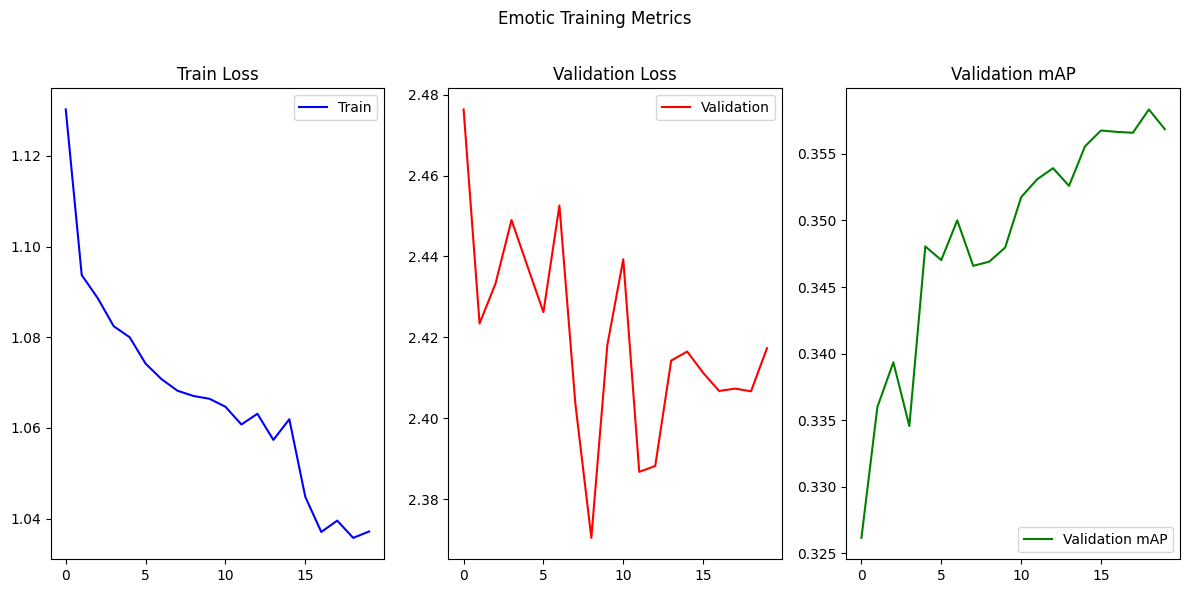

In [61]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))  # Adjusted figsize
f.suptitle('Emotic Training Metrics')

# Train loss plot
ax1.plot(range(0, len(train_loss)), train_loss, color='Blue')
ax1.set_title('Train Loss')
ax1.legend(['Train'], loc='upper right')

# Validation loss plot
ax2.plot(range(0, len(validation_loss)), validation_loss, color='Red')
ax2.set_title('Validation Loss')
ax2.legend(['Validation'], loc='upper right')

# Validation mAP plot
ax3.plot(range(0, len(val_map)), val_map, color='Green')
ax3.set_title('Validation mAP')
ax3.legend(['Validation mAP'], loc='lower right')

# Show the plots
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top margin for the suptitle
plt.show()

## **Testing**

In [62]:
# '''
# get thresholded trên tập val trước r dùng vs khi testinig

# '''

In [63]:
def test_scikit_ap_(cat_preds, cat_labels, ind2cat):
    '''
    Calculate average precision per emotion category using sklearn library.
    :param cat_preds: Categorical emotion predictions.
    :param cat_labels: Categorical emotion labels.
    :param ind2cat: Dictionary converting integer index to categorical emotion.
    :return: Numpy array containing average precision per emotion category.
    '''
    ap = np.zeros(26, dtype=np.float32)
    for i in range(26):
        ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
        print('Category %16s %.5f' %(ind2cat[i], ap[i]))
    #print ('Mean AP %.5f' %(ap.mean()))
    return ap.mean()

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model = PNAPredictor(200, 256, 1 , 256, 1)
test_model.load_state_dict(torch.load('model_graphs.pth', weights_only=True))

test_model = test_model.to(device)
test_model.eval()

running_loss = 0.0
running_cat_loss = 0.0
# running_cont_loss = 0.0
indx = 0

cat_preds = np.zeros((len(test_dataset), 26))
cat_labels = np.zeros((len(test_dataset), 26))
# cont_preds = np.zeros((len(test_dataset), 3))
# cont_labels = np.zeros((len(test_dataset), 3))

test_model.eval()
with torch.no_grad():
    for label_cat, label_cont, indexes in iter(test_loader):
        graph_batch = []
        for index in indexes:
            graph = test_graphs[index]
            graph = graph.to(device)
            graph_batch.append(graph)
        graphs = dgl.batch(graph_batch)

        graphs = graphs.to(device)
        weights = graphs.edata['weight'].float()

        feats = graphs.ndata.pop('x')
        feats = feats.type(torch.float)
        feats = feats.to(device)

        pred_cat = model(graphs, feats, weights)
        pred_cat = pred_cat.to("cpu")
        # pred_cont = pred_cont.to("cpu")
        disc_loss_ = disc_loss(pred_cat, label_cat)
        # cont_loss_ = cont_loss(pred_cont*10, label_cont)
        loss = (cat_loss_param*disc_loss_) #+ cont_loss_param*cont_loss_
        running_loss += loss.item()
        running_cat_loss += disc_loss_.item()
        # running_cont_loss += cont_loss_.item()

        cat_preds[indx: (indx + pred_cat.shape[0]),
                    :] = pred_cat.to("cpu").data.numpy()
        cat_labels[indx: (indx + label_cat.shape[0]),
                    :] = label_cat.to("cpu").data.numpy()
        # cont_preds[indx: (indx + pred_cont.shape[0]),
        #             :] = pred_cont.to("cpu").data.numpy() * 10
        # cont_labels[indx: (indx + label_cont.shape[0]),
        #             :] = label_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cat.shape[0]
        pbar.update(1)

cat_preds = cat_preds.transpose()
cat_labels = cat_labels.transpose()
# cont_preds = cont_preds.transpose()
# cont_labels = cont_labels.transpose()

test_map_v = test_scikit_ap(cat_preds, cat_labels, ind2cat)
# test_vad_v = test_vad(cont_preds, cont_labels, ind2vad)

test_map_v = test_scikit_ap_(cat_preds, cat_labels, ind2cat)

print(f'test_mAP: {test_map_v}')

Category        Affection 0.37130
Category            Anger 0.13548
Category        Annoyance 0.12803
Category     Anticipation 0.57593
Category         Aversion 0.07062
Category       Confidence 0.76691
Category      Disapproval 0.11677
Category    Disconnection 0.26181
Category     Disquietment 0.17443
Category  Doubt/Confusion 0.19403
Category    Embarrassment 0.02873
Category       Engagement 0.85991
Category           Esteem 0.16924
Category       Excitement 0.70066
Category          Fatigue 0.13725
Category             Fear 0.07977
Category        Happiness 0.66150
Category             Pain 0.11433
Category            Peace 0.24307
Category         Pleasure 0.43941
Category          Sadness 0.29144
Category      Sensitivity 0.07350
Category        Suffering 0.21793
Category         Surprise 0.07996
Category         Sympathy 0.15296
Category         Yearning 0.10471
test_mAP: 0.27498874068260193
